## First Marshall1994 numerical method : Coalition vs Coalition 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize

from tqdm import tqdm_notebook as tqdm
import timeit

In [2]:
def display1(out) :
    plt.figure(figsize=(15,4.5))
    plt.suptitle(r"Coallition $k_1={}$ vs Coallition $k_2={}$".format(out['k1'],out['k2']))
    v_ = np.linspace(0,1,1001)
        
    plt.subplot(131)
    
    plt.semilogy(np.linspace(0,out['tstar'],out['N']+2),out['delta1_'],'b',label=r'$\delta_1$')
    plt.semilogy(np.linspace(0,out['tstar'],out['N']+2),out['delta2_'],'r',label=r'$\delta_2$')
    plt.axhline(out['l1'],color='b',linestyle='--')
    plt.axhline(1/out['tstar'],color='gray',linestyle='--')
    plt.axhline(out['l2'],color='r',linestyle='--')
    plt.ylim((min(out['l2'],out['l1'])-0.1,max(out['l2'],out['l1'])+0.1))
    
    plt.axvline(out['tstar']*out['breakpoint']/(out['N']+1),color='k',linewidth=2)
    
    plt.title(r"Approximated functions : $\delta_i(b) = \lambda_i(b)/b$")
    plt.legend()
    
    plt.subplot(132)
    b_ = np.linspace(0,out['tstar'],out['N']+2)
    plt.plot(b_,out['values1_'],'b',label=r'$\lambda_1$')
    plt.plot(b_,out['values2_'],'r',label=r'$\lambda_2$')
    plt.plot(b_,out['l1']*b_,'b--')
    plt.plot(b_,out['l2']*b_,'r--')
    
    plt.title(r"Value functions $\lambda_i$")
    plt.legend()
    plt.xlim((0,out['tstar']))
    plt.grid(True, which='both')
    
    plt.subplot(133)
    plt.plot(v_,[bid1_f(v,out) for v in v_],'b',label=r"$\phi_1$")
    plt.plot(v_,[bid2_f(v,out) for v in v_],'r',label=r"$\phi_2$")
    plt.plot(v_,1/out['l1']*v_,'b--')
    plt.plot(v_,1/out['l2']*v_,'r--')
    plt.axhline(out['tstar'],color='gray',linestyle='--')
    
    plt.title(r"Bid functions $\phi_i$")
    plt.legend()
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.grid(True, which='both')
    
    plt.show()

In [3]:
def marshall1_sub_method(tstar,k1,k2,N=10_000,p=5,correct=True) :
    l1 = 1+1/k2
    l2 = 1+1/k1
    
    output = {}
    output['tstar'] = tstar
    output['N']=N
    output['breakpoint'] = 0
    output['l1'] = l1
    output['l2'] = l2
    output['k1'] = k1
    output['k2'] = k2
    
    delta1_ = np.zeros(N+2)
    delta2_ = np.zeros(N+2)

    a_ = np.zeros(p+1)
    b_ = np.zeros(p+1)
    
    delta1_[N+1] = 1/tstar
    delta2_[N+1] = 1/tstar
    
    for j in np.arange(N+1,0,-1) : #j=N+1,...,1
        tj = tstar*j/(N+1)
                    
        #values at tj, equation (17)
        a_[0] = delta1_[j] 
        b_[0] = delta2_[j]
        
        ## updating the Taylors approximations astar_,bstar_ equations (19, 20)
        
        for l in range(p) :
            sum1 = np.sum([i*b_[l+1-i]*( a_[i-1]+tj*a_[i]) for i in range(1,l+1)])
            sum2 = np.sum([i*a_[l+1-i]*( b_[i-1]+tj*b_[i]) for i in range(1,l+1)])
    
            a_[l+1] = 1/((l+1)*(b_[0]-1)*tj) * ( (1/k1-(l+1)*(b_[0]-1))*a_[l]-sum1 )
            b_[l+1] = 1/((l+1)*(a_[0]-1)*tj) * ( (1/k2-(l+1)*(a_[0]-1))*b_[l]-sum2 )
        
        tjm1 = tstar*(j-1)/(N+1)
            
        delta1_[j-1] = np.polynomial.polynomial.polyval(tjm1-tj,a_) #updating at tj-1
        delta2_[j-1] = np.polynomial.polynomial.polyval(tjm1-tj,b_)
        
        if(output['breakpoint'] == 0 and ((delta1_[j-1]-l1)**2+(delta2_[j-1]-l2)**2 > ((delta1_[j]-l1)**2+(delta2_[j]-l2)**2))) :
            output['breakpoint'] = j
            if(correct) :
                break
    
    output['eps_star'] = np.sqrt(((delta1_[output['breakpoint']]-l1)**2+(delta2_[output['breakpoint']]-l2)**2))
    #output['precision'] = np.min(((delta1_-l1)**2+(delta2_-l2)**2))
    if(correct) :
        ind = output['breakpoint']
        delta1_[:ind+1] = np.linspace(l1,delta1_[ind],ind+1)
        delta2_[:ind+1] = np.linspace(l2,delta2_[ind],ind+1)
        
        #patch_ = 1/(np.linspace(0,out['tstar'],out['N']+2)[1:])
        #delta1_[1:] = np.where(delta1_[1:] > patch_, patch_,delta1_[1:])
        #delta2_[1:] = np.where(delta2_[1:] > patch_, patch_,delta2_[1:])
        
    output['delta1_']=delta1_
    output['delta2_']=delta2_
    output['values1_']=np.linspace(0,tstar,N+2)*delta1_
    output['values2_']=np.linspace(0,tstar,N+2)*delta2_
    return output

In [4]:
def marshall1_close_form_boundary(k1,k2,N=10_000,p=5,correct=True) :
    tstar = k1/(k1+1)
    
    if(k1!=k2) :
        tstar = 1-np.power(1+k1,k2/(k1-k2))/np.power(1+k2,k1/(k1-k2))*np.power((k2*(1+k1))/(k1*(1+k2)),k1*k2/(k1-k2))
        
    return marshall1_sub_method(tstar,k1,k2,N=N,p=p,correct=correct)

In [5]:
def marshall1_iterative_find_boundary_OPTIMIZE(k1,k2,method='bounded',maxiter=500,N=10_000,p=5,show_msg=False,correct=True) :
    l1 = 1+1/k2
    l2 = 1+1/k1
    
    lb = min(1/l1,1/l2)
    ub = max(1/l1,1/l2)
    
    precision_function = lambda tstar:marshall1_sub_method(tstar,k1,k2,N,p,correct=True)['eps_star']
    
    opt = optimize.minimize_scalar(precision_function,method=method,bracket=(lb,ub),bounds=(lb,ub),options={'maxiter':maxiter})
    if(show_msg) :
        print(opt)
    return marshall1_sub_method(opt.x,k1,k2,N=N,p=p,correct=correct)

In [6]:
def marshall1_iterative_find_boundary_CUSTOM(k1,k2,eps=10**-5,nb_eval_max=500,N=10_000,p=5,show_msg=False) :
    l1 = 1+1/k2
    l2 = 1+1/k1
    
    a = min(1/l1,1/l2)
    b = max(1/l1,1/l2)
    
    tau = (np.sqrt(5)-1)/2
    
    x_1 = a + (1-tau)*(b-a)
    f_1 = marshall1_sub_method(x_1,k1,k2,N,p,correct=True)
    
    x_2 = a + tau*(b-a)
    f_2 = marshall1_sub_method(x_2,k1,k2,N,p,correct=True)
    
    i=2
    while(f_1['eps_star']>eps and f_2['eps_star']>eps and i < nb_eval_max) :
        if(f_1['eps_star'] > f_2['eps_star']) :
            a = x_1
            x_1 = x_2
            f_1 = f_2
            x_2 = a + tau*(b-a)
            f_2 = marshall1_sub_method(x_2,k1,k2,N,p,correct=True)
        else :
            b = x_2
            x_2 = x_1
            f_2 = f_1
            x_1 = a + (1-tau)*(b-a)
            f_1 = marshall1_sub_method(x_1,k1,k2,N,p,correct=True)
        i+=1
    
    if(show_msg) :
        print("Nb of eval :",i)
        print("eps_star :",min(f_1['eps_star'],f_2['eps_star']))
        if(i==nb_eval_max) :
            print("Maximum number of evaluations reached")
            
    if(f_1['eps_star']<f_2['eps_star']) :
        return f_1
    else :
        return f_2

In [7]:
def bid1_f(v,method_out) :
    return method_out['tstar']*np.searchsorted(method_out['values1_'],v)/(method_out['N']+1)

def bid2_f(v,method_out) :
    return method_out['tstar']*np.searchsorted(method_out['values2_'],v)/(method_out['N']+1)

Nb of eval : 40
eps_star : 2.70728973031478e-06


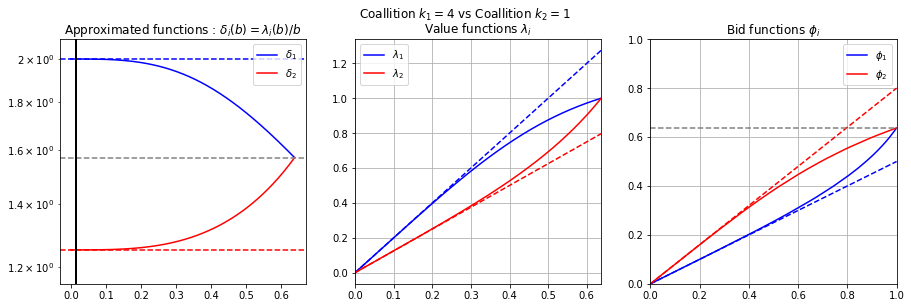

In [35]:
out1 = marshall1_iterative_find_boundary_CUSTOM(4,1,p=1,eps=10**-5,show_msg=True)
display1(out1)

Nb of eval : 45
eps_star : 6.67853711272912e-06


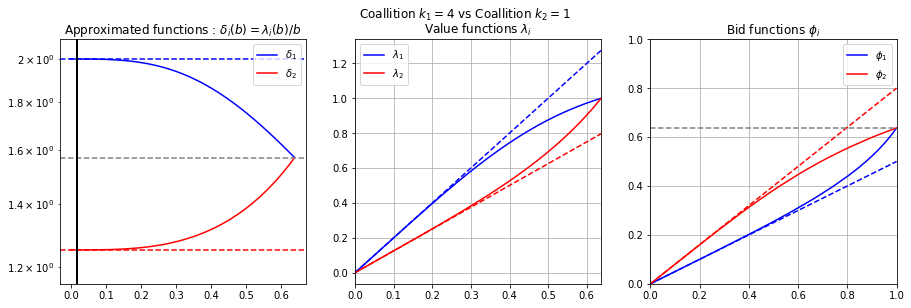

In [34]:
out5 = marshall1_iterative_find_boundary_CUSTOM(4,1,p=5,eps=10**-5,show_msg=True)
display1(out5)

In [38]:
np.linalg.norm(out1['values1_']-out5['values1_'],np.inf)

2.710781685899555e-06

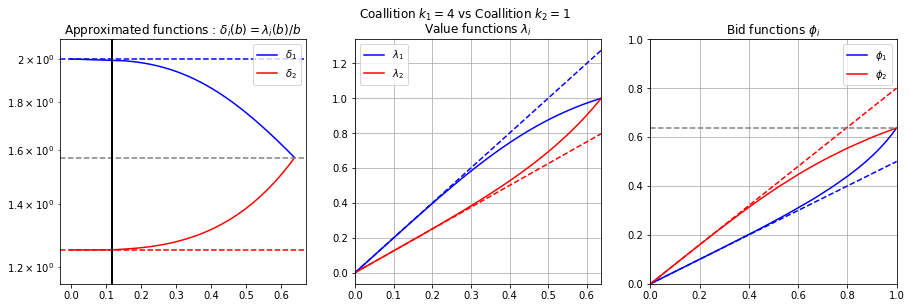

In [24]:
display1(out1)

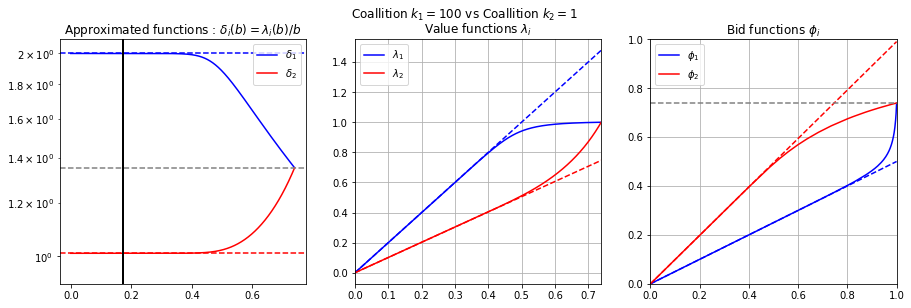

In [19]:
display1(out5)

## Tests - close form boundary $t_*$

Close form boundary 0.7076917426532907
eps_star 1.3711585259886066e-08


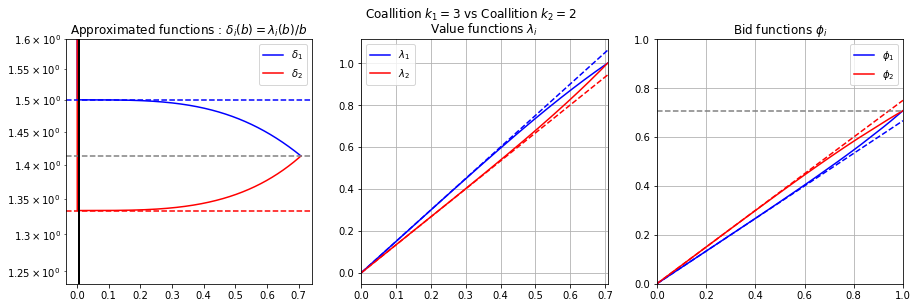

Close form boundary 0.6373758723740017
eps_star 3.687796978202491e-08


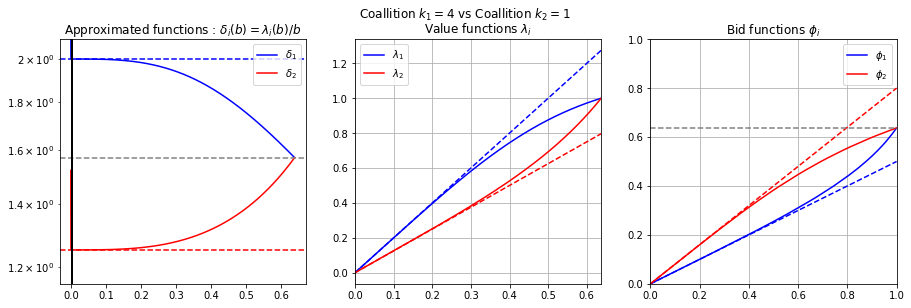

Close form boundary 0.7391028775601912
eps_star 1.0813117534721686e-07


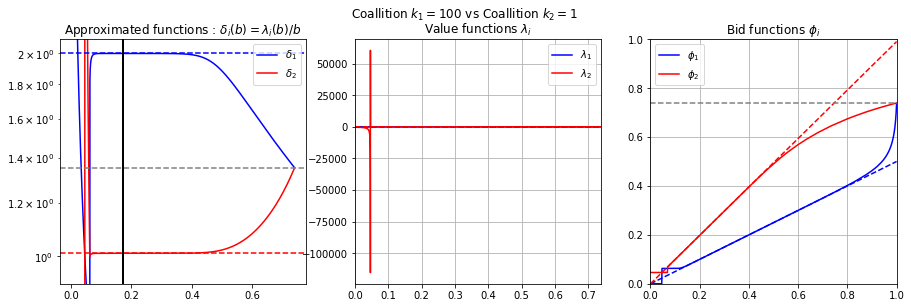

In [12]:
for (k1,k2) in [(3,2),(4,1),(100,1)] :
    out = marshall1_close_form_boundary(k1,k2,correct=False)
    print('Close form boundary', out['tstar'])
    print('eps_star', out['eps_star'])
    
    display1(out)

In [ ]:
for (k1,k2) in [(3,2),(4,1),(100,1)] :
    out = marshall1_close_form_boundary(k1,k2,correct=True)
    print('Close form boundary', out['tstar'])
    print('eps_star', out['eps_star'])
    
    display1(out)

## Tests - search boundary $t_*$

In [ ]:
for (k1,k2) in [(3,2),(4,1),(100,1)] :
    l1 = 1+1/k2
    l2 = 1+1/k1
    
    tstar = k1/(k1+1)
    if(k1!=k2) :
        C = ((1+k1)**k2)/((1+k2)**k1)*((k2*(1+k1))/(k1*(1+k2)))**(k1*k2)
        tstar = 1-C**(1/(k1-k2))

    out = marshall1_iterative_find_boundary_OPTIMIZE(k1,k2,correct=True,show_msg=True)
    
    print()
    print('Approximate boundary',out['tstar'])
    print('Close form boundary',tstar)
    print('eps_star',out['eps_star'])
    
    display1(out)

Nb of eval : 19
eps_star : 0.0006867011044953949

Approximate boundary 0.7076918380769581
Close form boundary 0.7076917426532907
eps_star 0.0006867011044953949


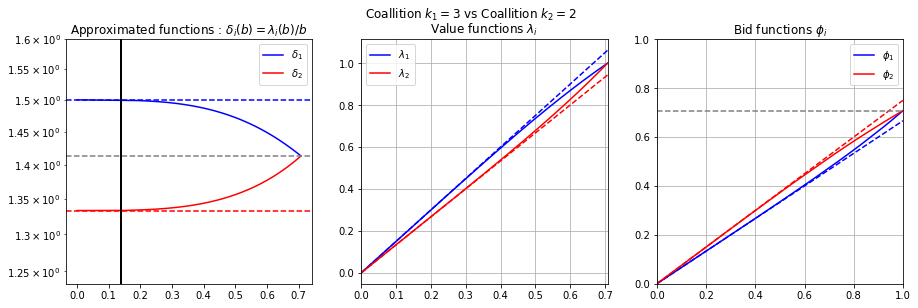

Nb of eval : 20
eps_star : 0.0009396027580579792

Approximate boundary 0.6373703178571619
Close form boundary 0.6373758723740016
eps_star 0.0009396027580579792


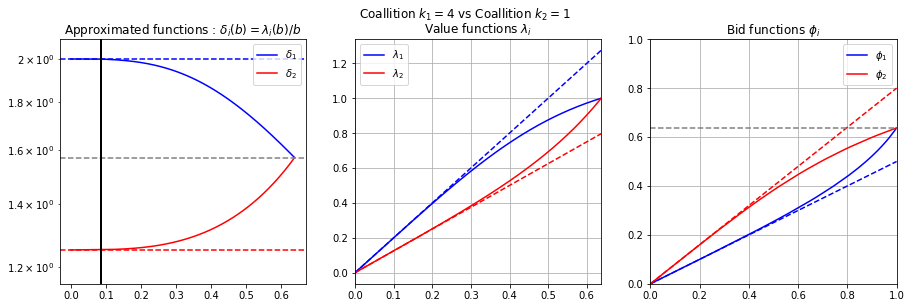

Nb of eval : 21
eps_star : 0.0007320635595807164

Approximate boundary 0.7390684684693132
Close form boundary 0.7391028775601913
eps_star 0.0007320635595807164


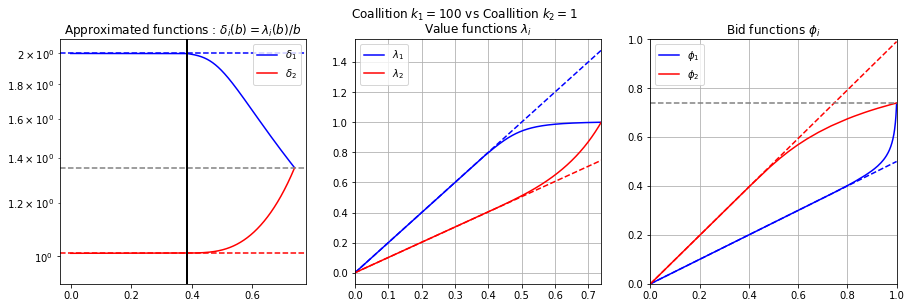

In [13]:
for (k1,k2) in [(3,2),(4,1),(100,1)] :
    l1 = 1+1/k2
    l2 = 1+1/k1
    
    tstar = k1/(k1+1)
    if(k1!=k2) :
        C = ((1+k1)**k2)/((1+k2)**k1)*((k2*(1+k1))/(k1*(1+k2)))**(k1*k2)
        tstar = 1-C**(1/(k1-k2))

    out = marshall1_iterative_find_boundary_CUSTOM(k1,k2,eps=10**-3,show_msg=True,p=1)
    
    print()
    print('Approximate boundary',out['tstar'])
    print('Close form boundary',tstar)
    print('eps_star',out['eps_star'])
    
    display1(out)

Nb of eval : 19
eps_star : 0.00028560600606685843

Approximate boundary 0.7076918380769581
Close form boundary 0.7076917426532907
eps_star 0.00028560600606685843


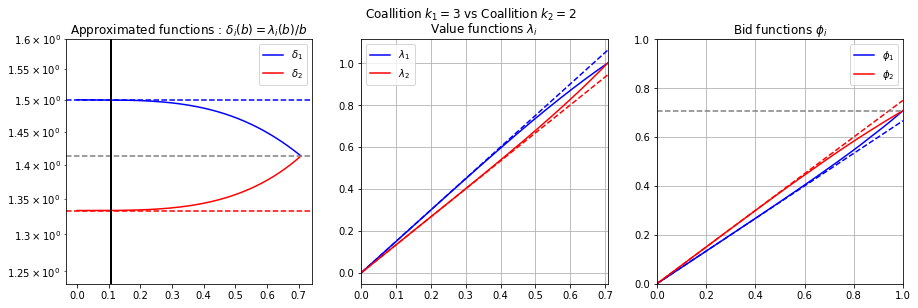

Nb of eval : 27
eps_star : 0.0007641701560016161

Approximate boundary 0.6373754217286804
Close form boundary 0.6373758723740016
eps_star 0.0007641701560016161


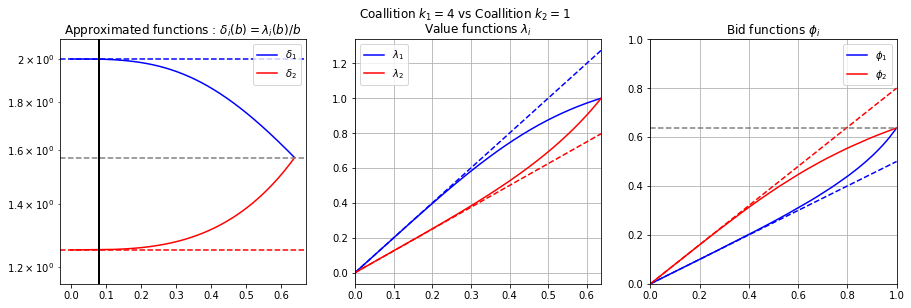

Nb of eval : 22
eps_star : 0.0007361983505690726

Approximate boundary 0.7390961404815987
Close form boundary 0.7391028775601913
eps_star 0.0007361983505690726


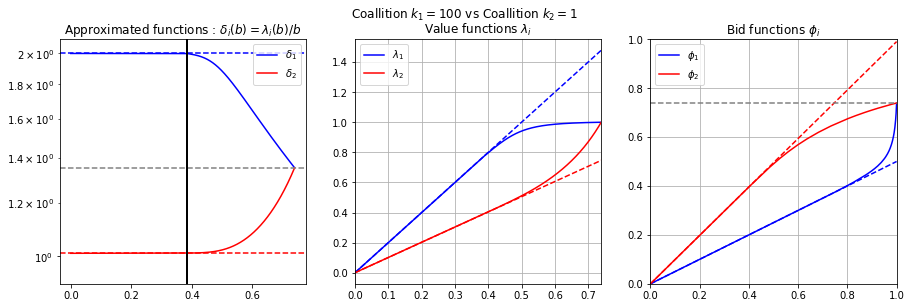

In [14]:
for (k1,k2) in [(3,2),(4,1),(100,1)] :
    l1 = 1+1/k2
    l2 = 1+1/k1
    
    tstar = k1/(k1+1)
    if(k1!=k2) :
        C = ((1+k1)**k2)/((1+k2)**k1)*((k2*(1+k1))/(k1*(1+k2)))**(k1*k2)
        tstar = 1-C**(1/(k1-k2))

    out = marshall1_iterative_find_boundary_CUSTOM(k1,k2,eps=10**-3,show_msg=True,p=5)
    
    print()
    print('Approximate boundary',out['tstar'])
    print('Close form boundary',tstar)
    print('eps_star',out['eps_star'])
    
    display1(out)

In [ ]:
for (k1,k2) in [(3,2),(4,1),(100,1)] :
    l1 = 1+1/k2
    l2 = 1+1/k1
    
    tstar = k1/(k1+1)
    if(k1!=k2) :
        C = ((1+k1)**k2)/((1+k2)**k1)*((k2*(1+k1))/(k1*(1+k2)))**(k1*k2)
        tstar = 1-C**(1/(k1-k2))

    out = marshall1_iterative_find_boundary_OPTIMIZE(k1,k2,correct=False,show_msg=True)
    
    print()
    print('Approximate boundary',out['tstar'])
    print('Close form boundary',tstar)
    print('eps_star',out['eps_star'])
    
    display1(out)

## Garbage

In [ ]:
k1,k2 = 3,47
print(((1+k1)**k2)/((1+k2)**k1)*((k2*(1+k1))/(k1*(1+k2)))**(k1*k2))

k1,k2 = np.array([3])[0],np.array([47])[0]
print(((1+k1)**k2)/((1+k2)**k1)*((k2*(1+k1))/(k1*(1+k2)))**(k1*k2))

k1,k2 = 3,47
print ( np.power(1+k1,k2)/np.power(1+k2,k1)*np.power((k2*(1+k1))/(k1*(1+k2)),k1*k2) )

k1,k2 = np.array([3])[0],np.array([47])[0]
print ( np.power(1+k1,k2)/np.power(1+k2,k1)*np.power((k2*(1+k1))/(k1*(1+k2)),k1*k2) )

In [ ]:
def search_breakpoint(eps_) : 
    N = len(eps_)-2
    ind = N+1
    for j in np.flip(np.arange(N+2)) :
        if(eps_[j] <= eps_[ind]) :
            ind = j
        else :
            break
    return ind

In [ ]:
for (k1,k2) in [(3,1),(10,1),(50,1),(100,1),(500,1)] :
    output1 = marshall1_close_form_boundary(k1,k2)
    print("Close-form method : precision ",output1['precision'], "| tstar ",output1['tstar'])
    plt.plot(np.linspace(0,1,101),[bid1_f(v,output1) for v in np.linspace(0,1,101)],'b--',label=r'$b_1$')
    plt.plot(np.linspace(0,1,101),[bid2_f(v,output1) for v in np.linspace(0,1,101)],'r--',label=r'$b_2$')

    #plt.plot(np.linspace(0,output1['tstar'],10_000+1),output1['values1_'],'b--',label=r'$b_1$')
    #plt.plot(np.linspace(0,output1['tstar'],10_000+1),output1['values2_'],'r--',label=r'$b_2$')
    #plt.plot(np.linspace(0,output2['tstar'],10_000+1),output2['values1_'],'b+')
    #plt.plot(np.linspace(0,output2['tstar'],10_000+1),output2['values1_'],'r+')

    plt.title("bid functions for k1={}, k2={}".format(k1,k2))
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.grid()
    plt.legend()
    plt.show()

In [ ]:
def marshall1_sub_method_star(tstar,k1,k2,N=10_000,p=5) :
    """
    Star version
    """
    delta1_ = np.zeros(N+1)
    delta2_ = np.zeros(N+1)
    
    delta1_[-1] = 1/tstar
    delta2_[-1] = 1/tstar
    
    for j in np.arange(N,0,-1) :
        tj = tstar*(j +1)/(N+1)
        tjm1 = tstar*(j-1 +1)/(N+1)
        
        astar_ = np.zeros(p+1)
        bstar_ = np.zeros(p+1)
        
        astar_[0] = delta1_[j] #it's at tj
        bstar_[0] = delta2_[j]
        
        ## updating the Taylors approximations astar_,bstar_ equations (19, 20)
        
        for l in range(p) :
            sum1 = np.sum([i*bstar_[l+1-i]*( (tjm1-tj)*astar_[i-1]+tj*astar_[i]) for i in range(1,l+1)])
            sum2 = np.sum([i*astar_[l+1-i]*( (tjm1-tj)*bstar_[i-1]+tj*bstar_[i]) for i in range(1,l+1)])
    
            astar_[l+1] = 1/((l+1)*(bstar_[0]-1)*tj) * ( (1/k1-(l+1)*(bstar_[0]-1))*(tjm1-tj)*astar_[l]-sum1 )
            bstar_[l+1] = 1/((l+1)*(astar_[0]-1)*tj) * ( (1/k2-(l+1)*(astar_[0]-1))*(tjm1-tj)*bstar_[l]-sum2 )
        
        delta1_[j-1] = np.sum(astar_) #updating at tj-1
        delta2_[j-1] = np.sum(bstar_)
    
    #Print whether the criterion is satisfied or not
    l1 = 1+1/k2
    l2 = 1+1/k1
    
    output = {}
    output['precision']=np.min((delta1_-l1)**2+(delta2_-l2)**2)
    output['tstar'] = tstar
    output['values1_']=np.linspace(0,tstar,N+1)*delta1_
    output['values2_']=np.linspace(0,tstar,N+1)*delta2_
    output['N']=N
    return output

In [ ]:
k1=4; k2=1

lb = min(1/(1+1/k2),1/(1+1/k1))
ub = max(1/(1+1/k2),1/(1+1/k1))

l_out = marshall_approx_bis(lb,k1,k2)
u_out = marshall_approx_bis(ub,k1,k2)

out = l_out
if(u_out['precision']<l_out['precision']) :
    out = u_out

while(out['precision'] > 1) :
    print(lb,ub,l_out['precision'],u_out['precision'],out['precision'])
    
    if(l_out['precision']<u_out['precision']) :
        ub = (lb+ub)/2
        u_out = marshall_approx_bis(ub,k1,k2)
        
        if(u_out['precision']<l_out['precision']) :
            out = u_out
            
    else :
        lb = (lb+ub)/2
        l_out = marshall_approx_bis(lb,k1,k2)
        
        if(l_out['precision']<u_out['precision']) :
            out = l_out